# Figure 4 : one example to showcase RSA with physio toolbox on rat ECG+RESP

This notebook is a demo of what can be done with the `physio` toolbox on a rat dataset.

Dataset can be downloaded here https://zenodo.org/record/8019849

The dataset is a text file in format tabular separated value.

First column is ECG.
Second column is resp.

sample rate 500Hz




In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats

import physio

In [16]:
plt.rcParams.update({
    'font.size': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,

})


In [17]:
data_folder = Path('/home/samuel/Documents/physio_benchmark/data')
# data_folder = Path('/home/samuel.garcia/Documents/physio_benchmark/data')

data_file = data_folder / 'rat' / 'R00.txt'

In [18]:
data = np.loadtxt(data_file)
data.shape
raw_ecg = data[:, 0]
raw_resp = data[:, 1]

srate = 500.
times = np.arange(raw_ecg.size) / srate

# compute ecg rpeak, resp cycle and rsa

In [19]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_preset='rat_ecg')

parameters = physio.get_respiration_parameters('rat_etisens_belt')
parameters['cycle_detection']['epsilon_factor1'] = 50.
resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameters=parameters)

rate_times = np.arange(0, times[-1], 1/100.)
instantaneous_cardiac_rate = physio.compute_instantaneous_rate(ecg_peaks, rate_times, limits=None,
                                                        units='bpm', interpolation_kind='linear')    



In [20]:
points_per_cycle = 100
rsa_cycles, cyclic_cardiac_rate = physio.compute_rsa(resp_cycles, ecg_peaks, srate=100., units='bpm', two_segment=True, points_per_cycle=points_per_cycle)

In [21]:
respiratory_duration_cut = 0.6 # s

Text(0.5, 0, 'cycle duration')

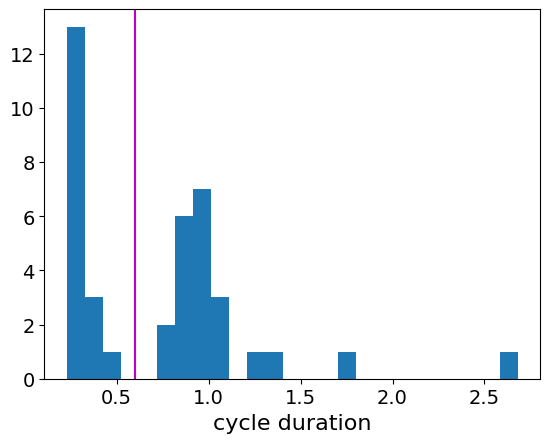

In [22]:
fig, ax = plt.subplots()
ax.hist(resp_cycles['cycle_duration'], bins=25)
ax.axvline(respiratory_duration_cut, color='m')
ax.set_xlabel('cycle duration')

# make figure 4

In [23]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [24]:
color_fast ='#D35400'
color_slow = '#16A085'

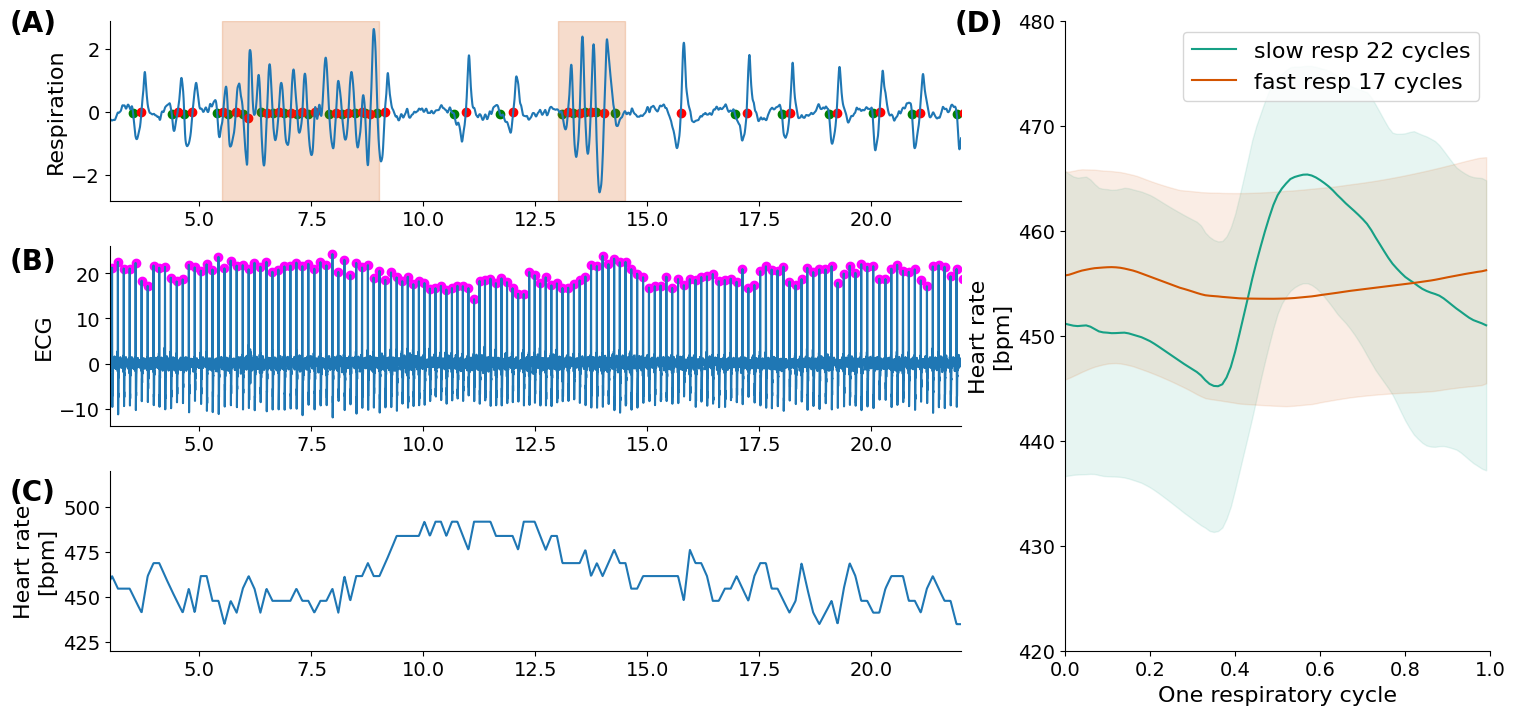

In [28]:
fig = plt.figure(layout="constrained", figsize=(15, 7))
gs = plt.GridSpec(nrows=3, ncols=6, figure=fig)


ax = fig.add_subplot(gs[0, :4])
simpleaxis(ax)
ax.plot(times, resp)
inspi_index = resp_cycles['inspi_index'].values
expi_index = resp_cycles['expi_index'].values
ax.scatter(times[inspi_index], resp[inspi_index], marker='o', color='green')
ax.scatter(times[expi_index], resp[expi_index], marker='o', color='red')
ax.axvspan(5.5, 9, color=color_fast, alpha=0.2)
ax.axvspan(13, 14.5, color=color_fast, alpha=0.2)
ax.set_ylabel('Respiration')


ax = fig.add_subplot(gs[1, :4], sharex=ax)
simpleaxis(ax)
ax.plot(times, ecg)
ecg_peak_ind = ecg_peaks['peak_index'].values
ax.scatter(times[ecg_peak_ind], ecg[ecg_peak_ind], marker='o', color='magenta')
ax.set_ylabel('ECG')


ax = fig.add_subplot(gs[2, :4], sharex=ax)
simpleaxis(ax)
ax.plot(rate_times, instantaneous_cardiac_rate)
ax.set_ylabel('Heart rate\n[bpm]')
ax.set_ylim(420, 520.)

ax.set_xlim(3, 22)


ax = fig.add_subplot(gs[:, 4:])
simpleaxis(ax)
one_cyle = np.arange(points_per_cycle) / points_per_cycle

slow_mask = resp_cycles['cycle_duration'].values > respiratory_duration_cut
m = np.mean(cyclic_cardiac_rate[slow_mask], axis=0)
s = np.std(cyclic_cardiac_rate[slow_mask], axis=0)
n = np.sum(slow_mask)
ax.plot(one_cyle, m, label=f'slow resp {n} cycles', color=color_slow)
ax.fill_between(one_cyle,m-s, m+s, alpha=0.1, color=color_slow)

fast_mask = resp_cycles['cycle_duration'].values < respiratory_duration_cut
m = np.mean(cyclic_cardiac_rate[fast_mask], axis=0)
s = np.std(cyclic_cardiac_rate[fast_mask], axis=0)
n = np.sum(fast_mask)
ax.plot(one_cyle, m, label=f'fast resp {n} cycles', color=color_fast)
ax.fill_between(one_cyle,m-s, m+s, alpha=0.1, color=color_fast)

ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel('One respiratory cycle')
ax.set_ylim(420, 480.)
ax.set_ylabel('Heart rate\n[bpm]')



fig.text(0.0, 1., '(A)', weight='bold', va='top', fontsize=20)
fig.text(0.0, 0.66, '(B)', weight='bold', va='top', fontsize=20)
fig.text(0.0, 0.33, '(C)', weight='bold', va='top', fontsize=20)
fig.text(0.63, 1., '(D)', weight='bold', va='top', fontsize=20)


fig.savefig('figure4.png')